In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
from google.colab import files
files.upload()

{}

In [12]:
!cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [13]:
!kaggle datasets download -d nih-chest-xrays/sample

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 113, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [14]:
import zipfile
zip_ref = zipfile.ZipFile('sample.zip', 'r')
zip_ref.extractall('/')
zip_ref.close()


FileNotFoundError: ignored

In [42]:
!unzip sample.zip -d "drive/My Drive/NIH_dataset/images"


unzip:  cannot find or open sample.zip, sample.zip.zip or sample.zip.ZIP.


In [41]:
!mkdir NIH_data

mkdir: cannot create directory ‘NIH_data’: File exists


In [0]:
import os
import glob
import cv2


In [43]:
images_path = glob.glob('/NIH_data/images/'+'*.png')
print(images_path)
i = 0
for img in images_path:
  img_file = cv2.imread(img)
  resized_image = cv2.resize(img_file,(256,256))
  

[]


In [0]:
#!mv images "drive/My Drive/NIH_dataset"

In [0]:
import os
import pandas as pd
import glob
import numpy as np
import tensorflow
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import load_model, Model, Sequential

In [0]:
#PATH = os.path.abspath(os.path.join('', 'drive/My Drive/NIH_dataset/images/images'))
#images = glob.glob(os.path.join(PATH, "*.png"))

In [45]:
labels = pd.read_csv('drive/My Drive/NIH_dataset/sample_labels.csv')
PATH = os.path.abspath(os.path.join('', 'drive/My Drive/NIH_dataset/images/images'))
print(PATH)
images = {os.path.basename(x): x for x in 
                   glob.glob(os.path.join(PATH, "*.png"))}

labels['path'] = labels['Image Index'].map(images.get)
labels['Patient Age'] = labels['Patient Age'].map(lambda x: int(x[:-1]))
label_counts = labels['Finding Labels'].value_counts()[:15]
labels['Finding Labels'] = labels['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

from itertools import chain
all_labels = np.unique(list(chain(*labels['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]


#the classes as the headers
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        labels[c_label] = labels['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
        
MIN_CASES = 99
all_labels = [c_label for c_label in all_labels if labels[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(labels[c_label].sum())) for c_label in all_labels])

/content/drive/My Drive/NIH_dataset/images/images
Clean Labels (11) [('Atelectasis', 508), ('Cardiomegaly', 141), ('Consolidation', 226), ('Edema', 118), ('Effusion', 644), ('Emphysema', 127), ('Infiltration', 967), ('Mass', 284), ('Nodule', 313), ('Pleural_Thickening', 176), ('Pneumothorax', 271)]


In [0]:
sample_weights = labels['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
labels = labels.sample(5606, weights=sample_weights)

In [0]:
labels['disease_vec'] = labels.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [23]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(labels, 
                                test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = labels['Finding Labels'].map(lambda x: x[:4]))
print('train', train.shape[0], 'validation', validation.shape[0])

train 3924 validation 1682


In [0]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [0]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]    
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [26]:
train_gen = flow_from_dataframe(core_idg, train, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, validation, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               validation, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3924 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1682 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1682 images


In [0]:
def create_model(all_labels):
    classifier = Sequential()
# Step 1 - Convolution
    classifier.add(Conv2D(64, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(Flatten())
# Step 3 - Dense layer
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = 64, activation = 'relu'))
    classifier.add(Dense(units = len(all_labels), activation = 'sigmoid'))
# Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    classifier.summary()
    return classifier
#for categorical entropy, as the loss function accuracy was low, ans activation as softmax, acuuracy was low,
# for LetNET the accuracy around 12-15%

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
#weight_path="{}_weights.best.hdf5".format('xray_class')

#checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                            # save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [early]

In [29]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [30]:
classifier = create_model(all_labels)
history = classifier.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 64)        73792     
__________

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
classifier.save('model_2.h5')
model_file = drive.CreateFile({'title' : 'model_2.h5'})

In [34]:
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': None})

In [35]:
file_obj = drive.CreateFile({'id': 'None'})                      
file_obj.GetContentFile('keras.h5')


ApiRequestError: ignored

In [36]:
classifier = create_model(all_labels)
classifier.load_weights('drive/My Drive/model_2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 59, 59, 64)        73792     
__________

In [37]:
pred_Y = classifier.predict(test_X, batch_size = 32, verbose = True)


256/256 [==============================] - 2s 7ms/step


In [38]:
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 10.55%, PDx: 11.04%
Cardiomegaly: Dx: 2.34%, PDx: 1.81%
Consolidation: Dx: 2.73%, PDx: 4.64%
Edema: Dx: 3.91%, PDx: 1.95%
Effusion: Dx: 14.06%, PDx: 7.25%
Emphysema: Dx: 1.17%, PDx: 1.85%
Infiltration: Dx: 20.70%, PDx: 16.11%
Mass: Dx: 5.08%, PDx: 4.41%
Nodule: Dx: 2.34%, PDx: 5.48%
Pleural_Thickening: Dx: 1.95%, PDx: 3.16%
Pneumothorax: Dx: 3.52%, PDx: 3.79%


In [39]:
sickest_idx = np.argsort(np.sum(test_Y, 1)>1)
for idx in sickest_idx:
    original_tags = [n_class[:4] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_tag = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    print('Original: '+', '.join(original_tags)+'\nPredicted: '+', '.join(pred_tag))
    print('\n')

Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Atel
Predicted: Atel:14%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Nodu
Predicted: Nodu: 5%


Original: 
Predicted: 


Original: 
Predicted: 


Original: Edem
Predicted: Edem: 3%


Original: Card
Predicted: Card: 3%


Original: Infi
Predicted: Infi:11%


Original: 
Predicted: 


Original: 
Predicted: 


Original: Infi
Predicted: Infi:11%


Original: Mass
Predicted: Mass: 2%


Original: Infi
Predicted: Infi: 8%


Original: 
Predicted: 


Original: Infi
Predicted: Infi:27%


Original: Card
Predicted: Card: 2%


Original: 
Predicted: 


Original: Edem
Predicted: Edem: 3%


Original: 
Predicted: 


Original: Effu
Predicted: Effu:18%


Original: Card
Predicted: Card: 3%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicte

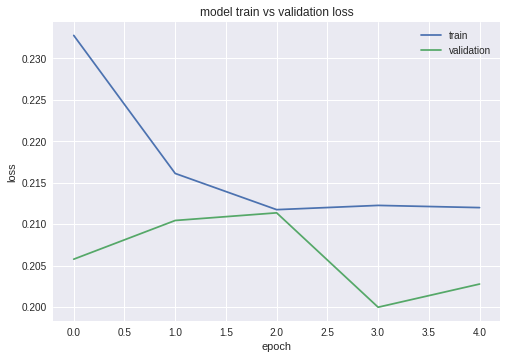

In [40]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()
